In [1]:
%%capture
!pip install eli5
!pip install dataprep
!pip install sentencepiece

In [108]:
import pandas as pd
import eli5
import re
import numpy as np
import nltk

from dataprep.eda import plot, plot_correlation, create_report, plot_missing

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [109]:
sklearn.__version__

'0.22.2.post1'

# Check dataframes

In [110]:
song_data = pd.read_csv("song_data.csv")
df_exp = pd.read_csv("explicit.csv")

In [116]:
%%capture
df_exp = df_exp[['artist','song','text','explicit_label']]
re_drop = re.compile(r'\n')        
df_exp[['text']] = df_exp[['text']].applymap(lambda x:re_drop.sub(' ',x))

In [117]:
df_exp.explicit_label = 'True'

In [7]:
# pd.Series(list(set(song_data.artist).intersection(set(df_exp.artist))))

In [118]:
song_data = song_data[['artist','song','text','explicit_label']]
song_data = song_data.loc[song_data['explicit_label'] != 'no match']
re_drop = re.compile(r'\n')        
song_data[['text']] = song_data[['text']].applymap(lambda x:re_drop.sub(' ',x))

song_data

,artist,song,text,explicit_label
1,ABBA,"Andante, Andante","Take it easy with me, please Touch me gently...",False
2,ABBA,As Good As New,I'll never know why I had to go Why I had to...,False
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...,False
7,ABBA,Chiquitita,"Chiquitita, tell me what's wrong You're ench...",False
11,ABBA,Dancing Queen,"You can dance, you can jive, having the time o...",False
...,...,...,...,...
57593,Zao,To Think Of You Is To Treasure An Absent Memory,When you shut your eyes and fell asleep Dark...,False
57605,Zebra,As I Said Before,And I said before I don't want no more And...,False
57608,Zebra,Hard Living Without You,Nothing to say no place to hide I can't find...,False
57609,Zebra,When You Get There,You wake up in the morning And you're not fe...,False


In [119]:
df_merged=pd.concat([df_exp,song_data],axis=0)

In [120]:
df_merged.explicit_label.unique()

array(['True', 'False'], dtype=object)

In [124]:
df_merged.head()

,artist,song,text,explicit_label
0,Chris Brown,D.G.I.F.U.,"[verse 1: tyga] ya'll know me, the still sam...",True
1,Lil Wayne,High Beamin,[b.g.] niggas be hating 'cause b.g. got it ...,True
2,Marilyn Manson,Unkillable Monster,how the fuck are we supposed to know when i'...,True
3,Ice Cube,It's A Man's World,women they're good for nothing no maybe one th...,True
4,Ariana Grande,Thinking Bout You,[verse 1] i've been thinking 'bout you yea...,True


In [123]:
df_merged['text'] = df_merged['text'].str.lower()

In [12]:
song_data[song_data['explicit_label'] == 'True']['text'].iloc[0]

"         I'm sitting in my chair watching the TV   It's not even on but there's plenty for me to see   I just lit some crazy ass shit   that my friend overnight mailed to me      I'm fucking wasted   It's the best shit I ever tasted   I think they fucking laced it   Cause I'm so damn lambasted      Oh my friend came over so I packed him a pipe   I told him he better go easy with this shit but he didn't believe the hype   He sparked three bows just to show he could take it   Two minutes later he was playing backgammon naked      He's fucking wasted   It's the best shit he ever tasted   He's lost in fucking spaced-ed   Cause he's so wicked wicked wasted      Oh I spent the last two hours   hiding under my bed   Cause I looked in the garbage can   and I think I saw my Uncle Louie's head      I'm fucking wasted      Well my friend blew a hit into my pet bird's face   The bird laughed hysterically and started to moonwalk all over the place   He tripped over the toaster wire and fell on his

In [125]:
df_merged['explicit_label'].value_counts()

False    28371
True      2900
Name: explicit_label, dtype: int64

# EDA

In [126]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import matplotlib.pyplot as plt
import seaborn as sns

from nltk import ngrams
from nltk import sentiment
# import tokenization
from wordcloud import STOPWORDS

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [127]:
# Metafeatures
df_merged['word_count'] = df_merged['text'].apply(lambda x: len(str(x).split()))
df_merged['unique_word_count'] = df_merged['text'].apply(lambda x: len(set(str(x).split())))
df_merged['stop_word_count'] = df_merged['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_merged['mean_word_length'] = df_merged['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_merged['char_count'] = df_merged['text'].apply(lambda x: len(str(x)))
df_merged['punctuation_count'] = df_merged['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [128]:
df_merged.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
count,31271.000000,31271.000000,31271.000000,31247.000000,31271.000000,31271.000000
mean,243.690384,102.704103,120.570113,3.962622,1273.544626,28.729526
std,129.637759,49.966557,64.701125,0.350407,651.464421,31.954336
min,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
25%,155.000000,72.000000,76.000000,3.742647,828.000000,7.000000
50%,212.000000,92.000000,107.000000,3.934010,1119.000000,20.000000
75%,293.000000,117.000000,149.000000,4.144894,1532.000000,39.000000
max,1143.000000,446.000000,570.000000,12.000000,5356.000000,332.000000



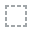
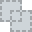
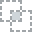
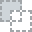
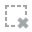
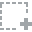
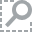
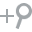
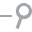
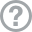
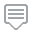
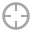
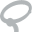
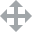
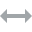
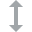
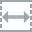
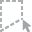
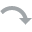
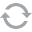
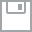
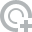
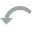
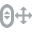
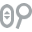
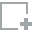
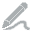
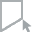
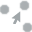
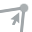
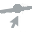

In [129]:
plot(df_merged)

DataPrep Report
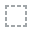
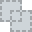
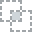
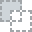
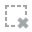
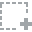
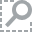
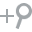
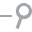
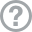
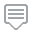
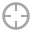
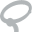
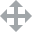
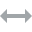
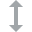
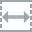
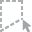
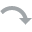
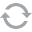
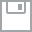
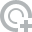
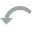
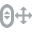
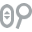
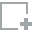
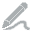
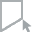
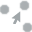
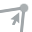
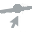

In [130]:
report_df = df_merged[['word_count', 'unique_word_count', 'stop_word_count','mean_word_length', 'char_count','punctuation_count']]
create_report(report_df)

In [131]:
# get_n_gramms
def get_ngrams_from_series(series, n=2):
    lines = ' '.join(series).lower().split('\n')
    lgrams = [ngrams(l.split(), n) for l in lines]
    grams = [[' '.join(g) for g in list(lg)] for lg in lgrams]
    return [item for sublist in grams for item in sublist]

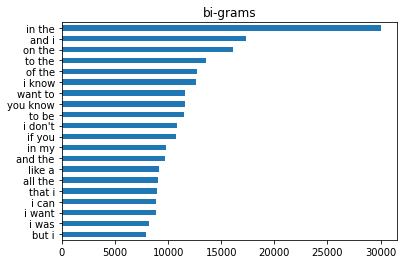

In [132]:
#Top bi-grams
pd.Series(get_ngrams_from_series(df_merged.text, 2)).value_counts()[:20][::-1].plot(kind='barh', title='bi-grams')

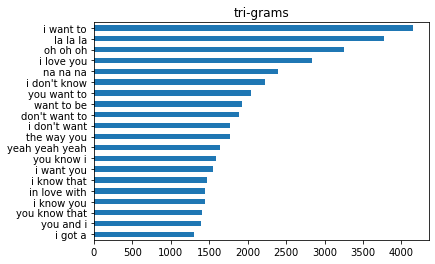

In [133]:
# Top tri-grams
pd.Series(get_ngrams_from_series(df_merged.text, 3)).value_counts()[:20][::-1].plot(kind='barh', title='tri-grams')

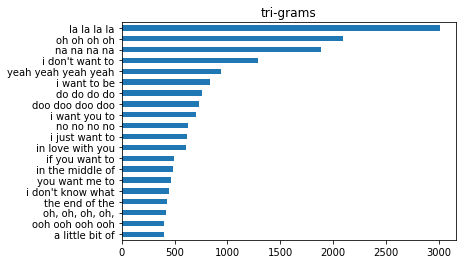

In [134]:
# Top 4-grams
pd.Series(get_ngrams_from_series(df_merged.text, 4)).value_counts()[:20][::-1].plot(kind='barh', title='tri-grams')

In [135]:
senti_analyze = sentiment.vader.SentimentIntensityAnalyzer()
df_merged['sentiment_score'] = pd.DataFrame(df_merged['text'].apply(senti_analyze.polarity_scores).tolist())['compound']
df_merged['sentiment'] = pd.cut(df_merged['sentiment_score'], [-np.inf, -0.25, 0.25, np.inf], labels=['negative', 'neutral', 'positive'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f296633ddd0>]],
      dtype=object)

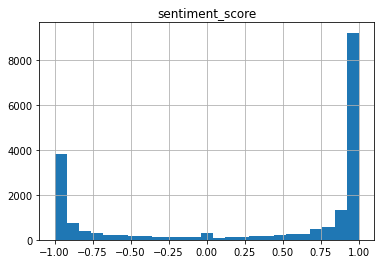

In [136]:
df_merged[['sentiment_score']].hist(bins=25)

# Train / test datasets

In [137]:
# rows with explicit = True
true_explicit = df_merged.loc[df_merged['explicit_label'] == 'True']

# rows with explicit = False
false_explicit = df_merged.loc[df_merged['explicit_label'] == 'False']
false_explicit = false_explicit.sample(n=6000, replace=False, random_state=100)
#song_data_0

# extract train / test data
x = false_explicit[['artist','song','text']].append(true_explicit[['artist','song','text']])
y = false_explicit[['explicit_label']].append(true_explicit[['explicit_label']])
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=2300, random_state=100)

In [138]:
train_label = []
for i in range(len(y_train)):
    l = y_train.iloc[i,0]
    if l=="False":
        l = 0
    else:
        l = 1
    train_label.append(l)

test_label = []
for i in range(len(y_test)):
    l = y_test.iloc[i,0]
    if l=="False":
        l = 0
    else:
        l = 1
    test_label.append(l)
    
train_data = []
for i in range(len(x_train)):
    text = x_train.iloc[i,2]
    train_data.append(text)
    
test_data = []
for i in range(len(x_test)):
    text = x_test.iloc[i,2]
    test_data.append(text)

# Feature creation using badwords 

## Import bad words list

In [139]:
file = open('bad_words.txt','r')
file = list(file)
bad_words = []
for w in file:
    bad_words.append(re.sub(r'\n','',w))

## Features creation (tf-idf)

In [140]:
class CustomFeats(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.feat_names = set()

    def fit(self, x, y=None):
        return self

    @staticmethod
    def features(review):
      return {
          'num_word': get_num_words(review),
          'bad_word': get_bad_words(review)
      }

    def get_feature_names(self):
        return list(self.feat_names)
      
    def transform(self, reviews):
      feats = []
      for review in reviews:
        f = self.features(review)
        [self.feat_names.add(k) for k in f] 
        feats.append(f)
      return feats

feats = FeatureUnion([
     ('custom', make_pipeline(CustomFeats(), DictVectorizer())),
     ('bag_of_words', TfidfVectorizer(stop_words='english', max_features=20000))
 ])

In [141]:
def get_bad_words(review):
  target_word = bad_words
  count = 0
  threshold = 0
  for t in target_word:
        if review.find(t) != -1:
            count += 1
  return count > threshold

def get_num_words(review):
  threshold = 0
  words = review.split(' ')
  count = len(list(words))
  return count > threshold

# Model creation

In [142]:

def classification(feats, model):  
  train_vecs = feats.fit_transform(train_data)
  test_vecs = feats.transform(test_data)
    
  model.fit(train_vecs, train_label)

  train_preds = model.predict(train_vecs)
  train_f1 = f1_score(train_label, train_preds, average='micro')

  test_preds = model.predict(test_vecs)
  test_f1 = f1_score(test_label, test_preds, average='micro')

  cm = confusion_matrix(test_label, test_preds)
  sns.heatmap(cm, annot=True)
  # print("Confusion Matrix : \n", cm, " \n")

  report = classification_report(test_label, test_preds)
  print(report)

  return model

## Grid search

In [143]:
# for decision tree classifier
train_vecs = feats.fit_transform(train_data)
test_vecs = feats.transform(test_data)
param_test = {'max_depth':list(range(60, 80, 1))} #
gsearch = GridSearchCV(estimator = DecisionTreeClassifier(),
                       param_grid = param_test, scoring='recall', iid=False, cv=5)
gsearch.fit(train_vecs, train_label)
gsearch.best_params_, gsearch.best_score_, gsearch.scorer_ #gsearch.grid_scores_, 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 79},
 0.8461538461538461,
 make_scorer(recall_score, average=binary))

## Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1610
           1       0.88      0.87      0.87       690

    accuracy                           0.93      2300
   macro avg       0.91      0.91      0.91      2300
weighted avg       0.93      0.93      0.93      2300



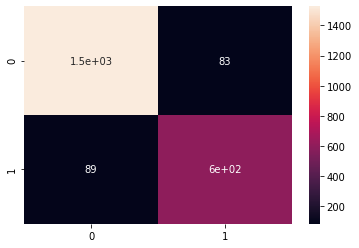

In [144]:
model_lo = LogisticRegression(C=50)
lr = classification(feats, model_lo)

## Random Forest

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1610
           1       0.94      0.85      0.89       690

    accuracy                           0.94      2300
   macro avg       0.94      0.91      0.93      2300
weighted avg       0.94      0.94      0.94      2300



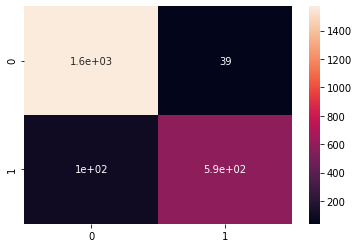

In [145]:
model_rf = RandomForestClassifier(n_estimators=120, max_depth=150, min_samples_split=20)
rf = classification(feats, model_rf)

## Decision Tree

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1610
           1       0.83      0.82      0.82       690

    accuracy                           0.89      2300
   macro avg       0.87      0.87      0.87      2300
weighted avg       0.89      0.89      0.89      2300



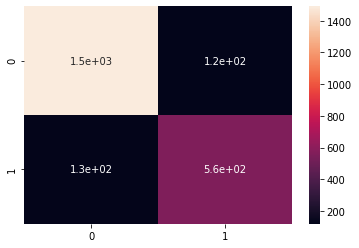

In [146]:
model_dt = DecisionTreeClassifier(min_samples_split=0.4, max_depth=77)
dt = classification(feats, model_dt)

## SVM

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1610
           1       0.90      0.87      0.89       690

    accuracy                           0.93      2300
   macro avg       0.92      0.91      0.92      2300
weighted avg       0.93      0.93      0.93      2300



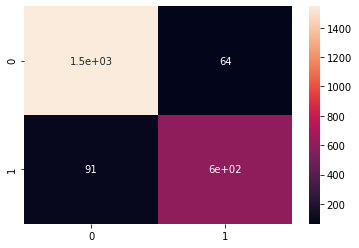

In [147]:
model_svm = SVC(C = 10000, kernel = 'rbf')
svm = classification(feats, model_svm)